# Exploratory Data Analysis (EDA) of Instacart data

## <u>Part I. Loading the datasets</u>

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
from IPython.display import display

# import matplotlib
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

color = sns.color_palette(['teal', 'darkorange', 'grey', 'forestgreen','maroon', 'deepskyblue'])

pd.options.mode.chained_assignment = None

%matplotlib inline
cmap_colors = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

# define the fig size of all figures
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
import os
wd = os.getcwd()
os.chdir('..')
new_wd = os.getcwd()

data_directory_path = new_wd + '\Data'

In [3]:
# ---------------------
# REMOVE
# ---------------------
print(data_directory_path)

C:\Users\Vinu\Documents\Python Scripts\Instacart\Data


In [3]:
# Converting the days and hours from numbers to their interpretable form
days_of_week = {0: 'Saturday', 
                1: 'Sunday', 
                2: 'Monday',
                3: 'Tuesday',
                4: 'Wednesday',
                5: 'Thursday',
                6: 'Friday'}
hour_nums = list(range(24))
hours_of_day = {hour_num:datetime.time(hour_num).strftime("%I:00 %p") for hour_num in hour_nums}
print(days_of_week)
print(hours_of_day)

{0: 'Saturday', 1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday'}
{0: '12:00 AM', 1: '01:00 AM', 2: '02:00 AM', 3: '03:00 AM', 4: '04:00 AM', 5: '05:00 AM', 6: '06:00 AM', 7: '07:00 AM', 8: '08:00 AM', 9: '09:00 AM', 10: '10:00 AM', 11: '11:00 AM', 12: '12:00 PM', 13: '01:00 PM', 14: '02:00 PM', 15: '03:00 PM', 16: '04:00 PM', 17: '05:00 PM', 18: '06:00 PM', 19: '07:00 PM', 20: '08:00 PM', 21: '09:00 PM', 22: '10:00 PM', 23: '11:00 PM'}


In [18]:
# ---------------------
# REMOVE
# ---------------------
# df = pd.DataFrame({'A': [0, 1, 2, 3, 4],
#                    'order_hour_of_day': [5, 6, 7, 8, 9],
#                    'C': ['a', 'b', 'c', 'd', 'e']})
# # Replacing numbers with their corresponding hour representation
# df['order_hour_of_day'] = df['order_hour_of_day'].replace(hours_of_day)
# df['order_hour_of_day'] = pd.Categorical(df['order_hour_of_day'], ordered=True, categories=list(hours_of_day.values()))
# # print(df)
# df['order_hour_of_day']

0    05:00 AM
1    06:00 AM
2    07:00 AM
3    08:00 AM
4    09:00 AM
Name: order_hour_of_day, dtype: category
Categories (24, object): ['12:00 AM' < '01:00 AM' < '02:00 AM' < '03:00 AM' ... '08:00 PM' < '09:00 PM' < '10:00 PM' < '11:00 PM']

In [4]:
def reduce_mem_usage(train_data):
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype
        
        if col_type not in [object, 'category']:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data

# Annotate text on graph
def annotate_text(p, append_to_text='%'):
    for p in ax.patches:
        txt = str(p.get_height().round(2)) + append_to_text
        txt_x = p.get_x() + p.get_width()/2.
        txt_y = 0.92*p.get_height()
        ax.text(txt_x,txt_y,txt, fontsize=20, color='#004235', ha='center', va='bottom')

In [5]:
aisles = pd.read_csv(data_directory_path + r'\aisles.csv')
aisles = reduce_mem_usage(aisles)

departments = pd.read_csv(data_directory_path + r'\departments.csv')
departments = reduce_mem_usage(departments)

order_products_prior = pd.read_csv(data_directory_path + r'\order_products__prior.csv')
order_products_prior = reduce_mem_usage(order_products_prior)

order_products_train = pd.read_csv(data_directory_path + r'\order_products__train.csv')
order_products_train = reduce_mem_usage(order_products_train)

orders = pd.read_csv(data_directory_path + r'\orders.csv')

# Replacing numbers with their corresponding hour representation
orders['order_hour_of_day'] = orders['order_hour_of_day'].replace(hours_of_day)
orders['order_hour_of_day'] = pd.Categorical(orders['order_hour_of_day'], ordered=True, categories=list(hours_of_day.values()))
# Replacing numbers with their corresponding day of week
# Define the categories of days of week sorted normally from Saturday to Friday
orders['order_dow'] = orders['order_dow'].replace(days_of_week)
orders['order_dow'] = pd.Categorical(orders['order_dow'], ordered=True, categories=list(days_of_week.values()))
orders = reduce_mem_usage(orders)

products = pd.read_csv(data_directory_path + r'\products.csv')
products = reduce_mem_usage(products)

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.01 MB
Decreased by -159.9%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by -92.7%
Memory usage of dataframe is 989.82 MB
Memory usage after optimization is: 340.25 MB
Decreased by 65.6%
Memory usage of dataframe is 42.26 MB
Memory usage after optimization is: 13.20 MB
Decreased by 68.7%
Memory usage of dataframe is 137.03 MB
Memory usage after optimization is: 45.68 MB
Decreased by 66.7%
Memory usage of dataframe is 1.52 MB
Memory usage after optimization is: 1.91 MB
Decreased by -25.8%


## <u>Part II. Understanding the data</u>

In [ ]:
df_list = %who_ls DataFrame
for df in df_list:
    print("================\n")
    print('Shape of ', df,' dataset: ', eval(df).shape)
    print(eval(df).info(), '\n')

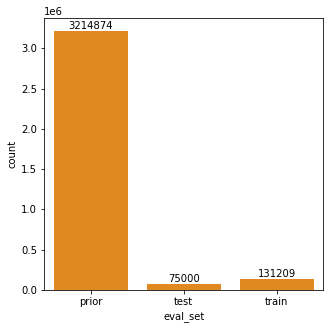

In [148]:
# Count of orders in prior, train and test evaluation set
plt.figure(figsize = (5,5))
p = sns.countplot(data = orders, x = 'eval_set', color = 'darkorange')
for i in p.containers:
    p.bar_label(i, fmt = '%d')


## <u>Part III. Data Preparation</u>

In [58]:
# Combining prior and train order sets
# Joining with orders, products, departments and aisles to collate all information 
order_products_all = pd.concat([order_products_prior, order_products_train])
order_details = order_products_all.merge(orders, on='order_id', how='left').merge(products, on='product_id', how='left').merge(departments, on='department_id').merge(aisles, on='aisle_id')

In [59]:
order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,Thursday,09:00 AM,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,22,23341,6,1,30822,prior,25,Sunday,08:00 AM,12.0,Large Grade AA Eggs,86,16,dairy eggs,eggs
2,25,6383,7,1,59897,prior,19,Friday,10:00 AM,25.0,All Whites 100% Egg Whites,86,16,dairy eggs,eggs
3,26,33120,5,0,153404,prior,2,Saturday,04:00 PM,7.0,Organic Egg Whites,86,16,dairy eggs,eggs
4,55,11520,12,0,127522,prior,8,Wednesday,02:00 PM,5.0,Large Alfresco Eggs,86,16,dairy eggs,eggs


In [60]:
# Columns in the combined dataset
order_details.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_name', 'aisle_id', 'department_id',
       'department', 'aisle'],
      dtype='object')

In [61]:
# Count of unique orders 
counts_orders = order_details.groupby('eval_set').agg({"order_id":pd.Series.nunique})
print("Count of unqiue orders in each set: \n", counts_orders)

Count of unqiue orders in each set: 
           order_id
eval_set          
prior      3214874
test             0
train       131209


In [93]:
# Count of unique users
print("Count of total unique users: ",order_details['user_id'].nunique())

count_users = order_details.groupby('eval_set').agg({"user_id":pd.Series.nunique}).rename(columns={'user_id':'count_users'})
print(count_users)

Count of total unique users:  206209
          Count_users
eval_set             
prior          206209
test                0
train          131209


#### <u>Findings</u>:
- There are a total of 206,209 users in the dataset.
- Their past orders (ranging from order_number 4 to 100) are given in evaluation set: 'prior' which amounts to 3,214,874 orders.
- Out of the total 206k users, the next order details for 131,209 of them are given in evaluation set: 'train' while the next order details for the remaining 75,000 denoted by evaluation set: 'test' need to be predicted. 

In [88]:
# Keeping only the data corresponding to prior orders for the EDA
order_details_prior = order_details[order_details['eval_set'] == 'prior']
order_details_prior['user_id'].nunique()

206209

## <u>Part IV. Exploratory Data Analysis (EDA)</u>

### Understanding Orders per User

In [105]:
df_orders_user_counts = order_details_prior.groupby(['user_id'], as_index=False).agg({"order_id":pd.Series.nunique}).rename(columns={'order_id':'order_counts'})
# df_orders_user_counts

,user_id,order_counts
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4
...,...,...
206204,206205,3
206205,206206,67
206206,206207,16
206207,206208,49


In [106]:
df_orders_user_counts['order_counts'].describe()

count    206209.000000
mean         15.590367
std          16.654774
min           3.000000
25%           5.000000
50%           9.000000
75%          19.000000
max          99.000000
Name: order_counts, dtype: float64

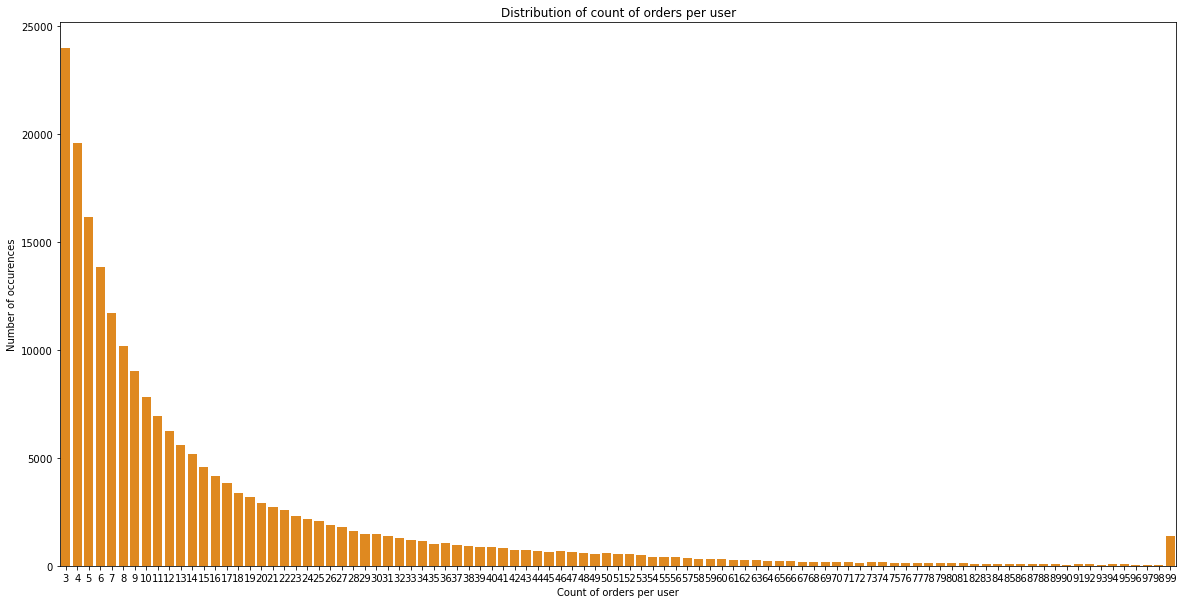

In [126]:
plt.figure(figsize=(20,10))
sns.countplot(x = 'order_counts', data = df_orders_user_counts, color = 'darkorange')
plt.xlabel('Count of orders per user')
plt.ylabel('Number of occurences')
plt.title('Distribution of count of orders per user')
plt.show()

# del df_orders_user_counts

#### <u>Findings</u>:
- Since order_number ranges from 4 - 100, count of orders per user also spans in this range approximately. However the distribution is right skewed.
- In spite of this huge range, 50% of the users have placed only 9 orders.
- Only one quarter of the users have placed >= 20 orders.

### Understanding Order placement by Day of Week and Time of Day

In [140]:
df_orders_dow_counts = order_details_prior.groupby(['order_dow'], as_index=False).agg({"order_id":pd.Series.nunique}).rename(columns={'order_id':'order_counts'})

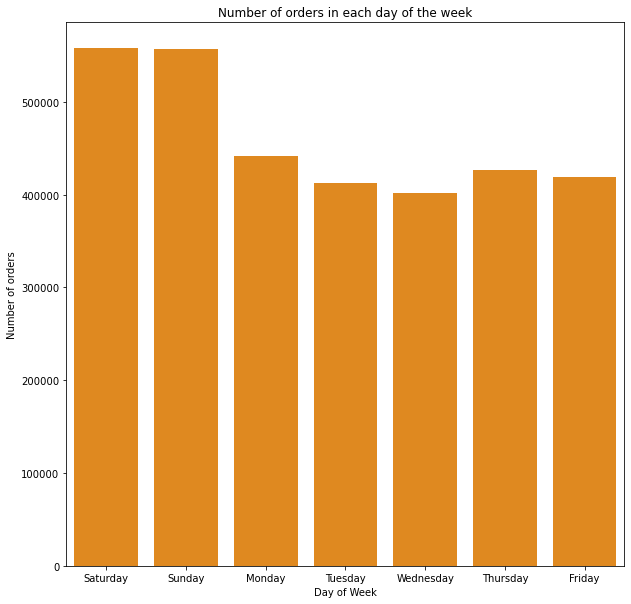

In [127]:
sns.barplot(x = 'order_dow', y = 'order_counts', data = df_orders_dow_counts, color = 'darkorange')
plt.xlabel('Day of Week')
plt.ylabel('Number of orders')
plt.title('Number of orders in each day of the week')
plt.show()

In [141]:
df_orders_hod_counts = order_details_prior.groupby(['order_hour_of_day'], as_index=False).agg({"order_id":pd.Series.nunique}).rename(columns={'order_id':'order_counts'})
# df_orders_hod_counts

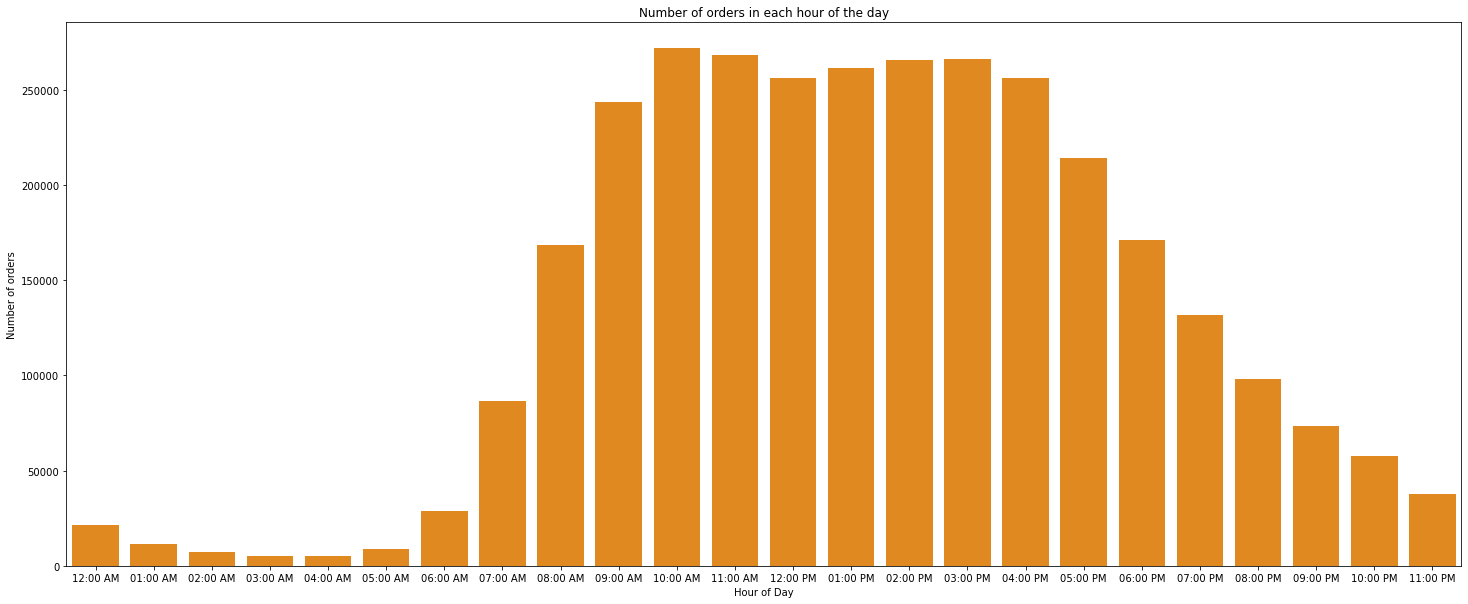

In [133]:
plt.figure(figsize=(25,10))
sns.barplot(x = 'order_hour_of_day', y = 'order_counts', data = df_orders_hod_counts, color = 'darkorange')
plt.xlabel('Hour of Day')
plt.ylabel('Number of orders')
plt.title('Number of orders in each hour of the day')
plt.show()

In [142]:
df_orders_dow_hod_counts = order_details_prior.groupby(['order_dow','order_hour_of_day'], as_index=False).agg({"order_id":pd.Series.nunique}).rename(columns={'order_id':'order_counts'})
# df_orders_dow_hod_counts
heatmap_data = df_orders_dow_hod_counts.pivot( 'order_hour_of_day','order_dow', 'order_counts')
# heatmap_data

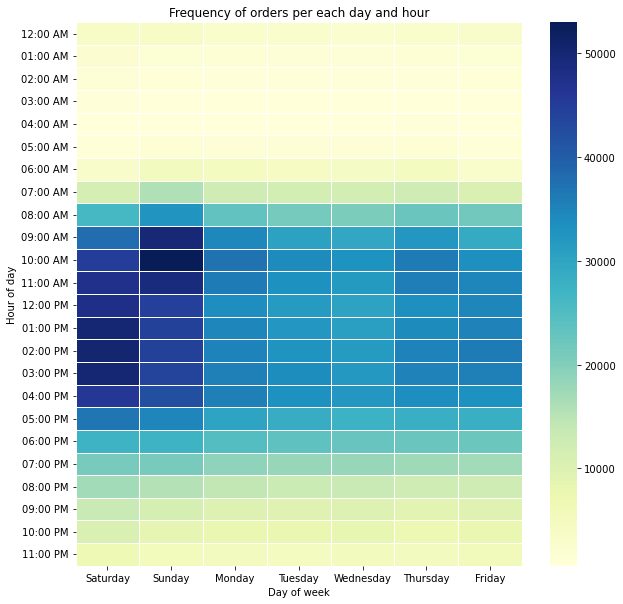

In [139]:
ax = sns.heatmap(data=heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title('Frequency of orders per each day and hour')
plt.ylabel('Hour of day')
plt.xlabel('Day of week')
plt.show()

#### <u>Findings</u>:
 - 10 AM to 4 PM are the busiest hours in a day garnering high volume of orders in this time period.
 - In a general week, maximum number of orders are placed on Saturday and Sunday.
 - Peak number of orders are placed at Saturday 2 PM and Sunday 10 AM.

### Understanding shop gap between orders

In [143]:
df_orders_shopgap_counts = order_details_prior.groupby(['days_since_prior_order'], as_index=False).agg({"order_id":pd.Series.nunique}).rename(columns={'order_id':'order_counts'})
# df_orders_shopgap_counts

,days_since_prior_order,order_counts
0,0.0,64436
1,1.0,141011
2,2.0,187723
3,3.0,210665
4,4.0,214488
5,5.0,206691
6,6.0,230245
7,7.0,306181
8,8.0,173259
9,9.0,112184


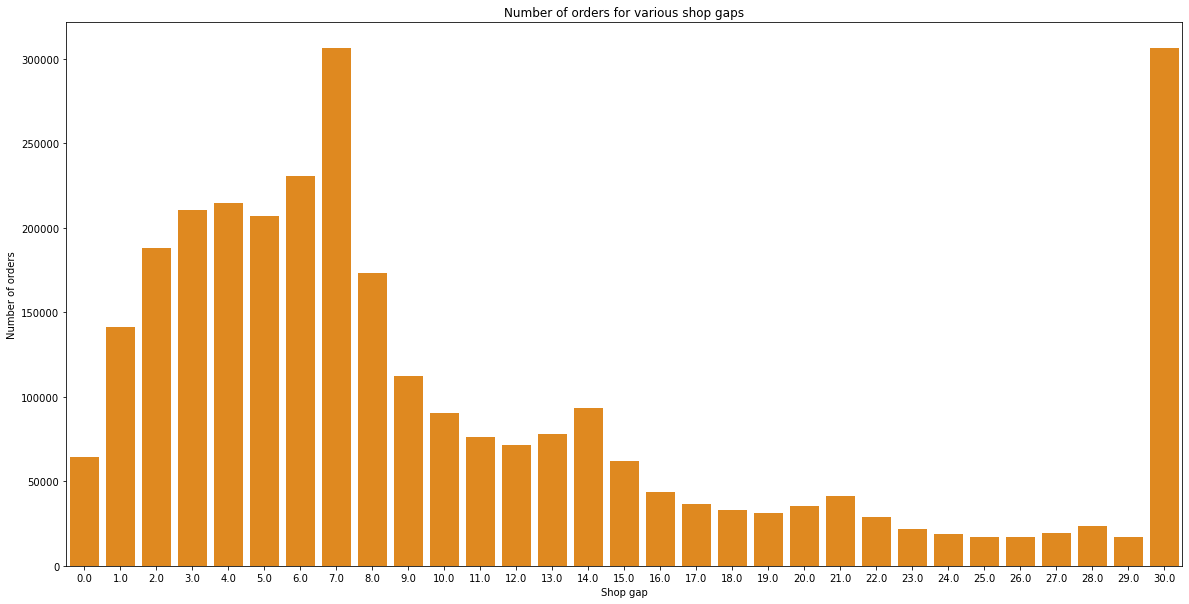

In [144]:
plt.figure(figsize=(20,10))
sns.barplot(x = 'days_since_prior_order', y = 'order_counts', data = df_orders_shopgap_counts, color = 'darkorange')
plt.xlabel('Shop gap')
plt.ylabel('Number of orders')
plt.title('Number of orders for various shop gaps')
plt.show()

#### <u>Findings</u>:
- Maximum number of orders are placed at an interval of one week (7 days) or one month (30 days) from the previous order. Compared to the total number of orders placed, Weekly and Monthly orders amount to 10% each.
- 60% of all orders are placed at a shop gap of 10 days or less.
- Shop gap between a week and a month is a lean time and probability of reordering is low.

### Understanding shop gap per user

In [151]:
df_user_shopgap_counts = order_details_prior.groupby(['user_id'], as_index=False)['days_since_prior_order'].mean().rename(columns={'days_since_prior_order':'avg_shop_gap'})
df_user_shopgap_counts

,user_id,avg_shop_gap
0,1,20.265625
1,2,15.968750
2,3,11.484375
3,4,15.359375
4,5,14.500000
...,...,...
206204,206205,20.671875
206205,206206,4.042969
206206,206207,14.882812
206207,206208,7.441406


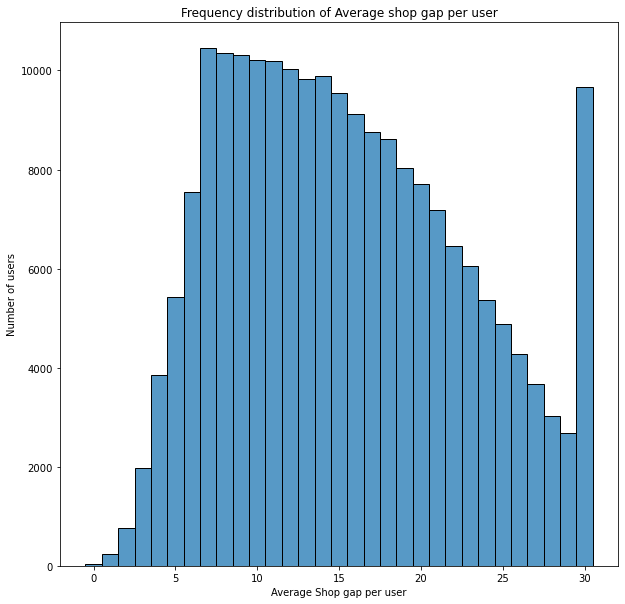

In [154]:
sns.histplot(data=df_user_shopgap_counts, x="avg_shop_gap", discrete = True)
plt.xlabel('Average Shop gap per user')
plt.ylabel('Number of users')
plt.title('Frequency distribution of Average shop gap per user')
plt.show()

In [ ]:
# order_details_prior

In [ ]:
# order_details_prior

In [ ]:
# order_details_prior

In [ ]:
# order_details_prior

In [ ]:
# order_details_prior

In [ ]:
# order_details_prior

In [ ]:
# order_details_prior

In [4]:
from subprocess import check_output
print(check_output(["ls", r"D:\Projects\Instacart product recommendation\Data"]).decode("utf8"))

FileNotFoundError: [WinError 2] The system cannot find the file specified